In [85]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import einops

from quant_func import STERound
from tqdm import tqdm

#aliases
torch.steRound = STERound.apply
torch.gelu = torch.nn.functional.gelu
torch.mul_reduce = torch.prod

In [86]:
# we will use the simplest dataset... ever
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True,transform=transform)

train_size = int(0.9 * len(mnist))  # 54000
test_size = len(mnist) - train_size  # 6000
train_dataset, test_dataset = random_split(mnist, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [87]:
for img,labels in train_loader:
    print(img.shape,labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [88]:
len(train_loader) # total training batches

844

tensor([1, 4, 9, 2, 9])


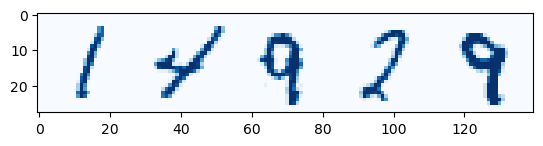

In [89]:
eg,eg_label = img[:5] , labels[:5]
eg = einops.rearrange(eg,"b c h w -> h (b w) c")
plt.imshow(eg,cmap="Blues")
print(eg_label)

In [90]:
class Qconv(torch.nn.Module):
    def  __init__ (self,in_channels,out_channels,kernel_size=3):
        super().__init__()
        # weight tying exp_bits and depth_bits
        # note number  of output  channels  is number of filterkernels  launched
        # we will try to not just compress  but take out entire filter kernels...
        # these asserts them to be pytorch tensors
        in_channels = torch.as_tensor(in_channels)
        out_channels = torch.as_tensor(out_channels)
        kernel_size = torch.as_tensor(kernel_size)

        
        # fan_in is just in_channels
        weight_scale = 1/ torch.sqrt(in_channels*out_channels*out_channels)
        self.weight = torch.ones(out_channels,in_channels,kernel_size,kernel_size)
        self.weight = self.weight.uniform_(-weight_scale,weight_scale)

        # 1 for each kernel (out_channel).. to perform safe broadcasting we have to fill the rest of them with 1
        self.exp_bit = torch.ones(out_channels,1,1,1)*-8.0
        self.depth_bit = torch.ones(out_channels,1,1,1)*4.0

        #register them as trainable parameters
        self.weight = torch.nn.Parameter(self.weight)
        self.exp_bit = torch.nn.Parameter(self.exp_bit)
        self.depth_bit = torch.nn.Parameter(self.depth_bit)
        ...
    
    def size_layer(self):
        """
        given by equation 4 : I*H*W * sum(b(i,l)
        Where O , I , H and W are the output, input, height, and
        width dimensions (so shape) of the weight tensor of layer l respec-
        tively, and b(i,l) is the bit depth of output channel i of layer l.
        """
        prods = torch.as_tensor(self.weight.shape[1:])
        size = torch.mul_reduce(prods) *  torch.sum(torch.relu(self.depth_bit))
        return size

    # @staticmethod
    def _init_weight(self,x,b):
        x_upscaled = x/torch.exp2(self.exp_bit)
        half = torch.exp2(b -1)
        x_clipped = torch.clip(x_upscaled,-1*half,half-1)
        x_round = torch.steRound(x_clipped)
        return torch.exp2(self.exp_bit) * x_round

    def __call__(self,x):
        # quantize every forward pass
        b = torch.relu(self.depth_bit)
        W = self._init_weight(self.weight,b)
        # assert self.weight.shape==W.shape
        # valid padding or should we do same.. paper does not say
        return torch.nn.functional.conv2d(x,W,padding=1)
        
        

torch.Size([5, 32, 28, 28])


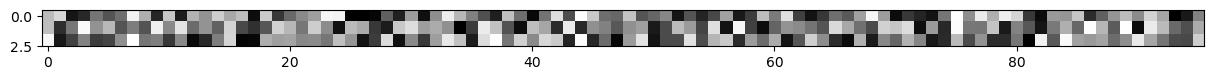

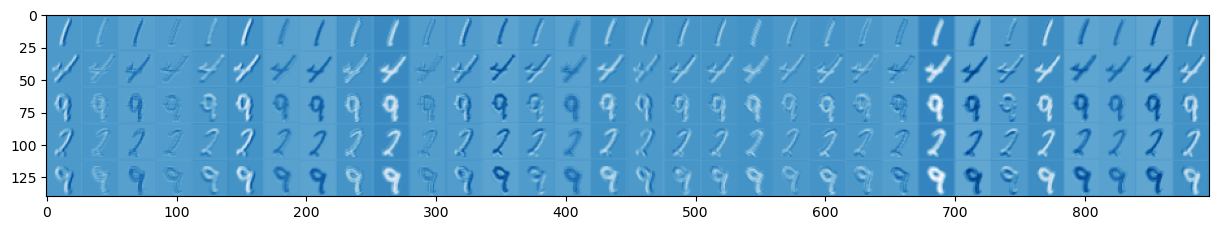

In [91]:
# example convolution (simple unit testing...)
#exemplar forward pass without pooling
input_img = img[:5] # 1,28,28
qconv_layer1 = Qconv(1,32)
qconv_layer2 = Qconv(32,48)

out1 = qconv_layer1(input_img)
out2 = qconv_layer2(out1)

print(out1.shape)
out_plot1 = einops.rearrange(out1,"b c h w -> (b h) (c w)")
out_plot2 = einops.rearrange(out2,"b c h w -> (b h) (c w)")

plt.figure(figsize=(15,8))
kernels1 = einops.rearrange(qconv_layer1.weight.detach(),"out_ch 1 k1 k2 -> k1 (out_ch k2)")
plt.imshow(kernels1,cmap="gray")
plt.show()
plt.figure(figsize=(15,8))
plt.imshow(out_plot1.detach(),cmap="Blues")
plt.show()


torch.Size([5, 48, 28, 28])


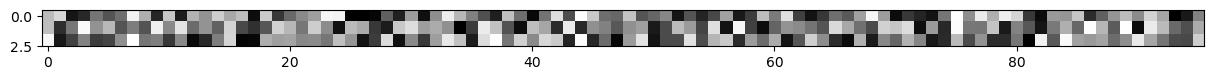

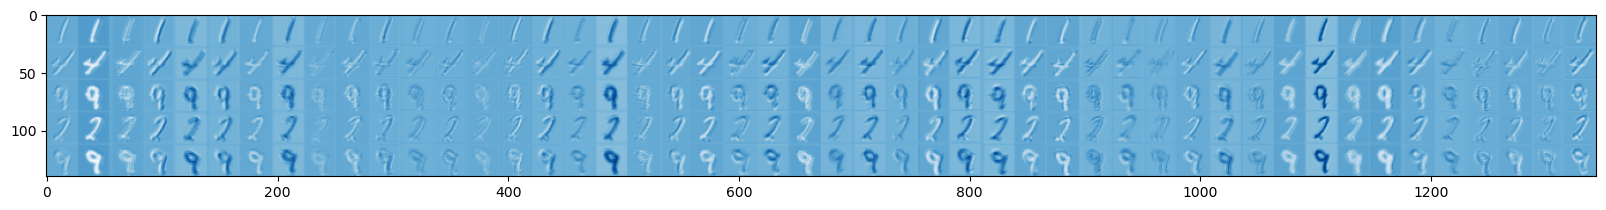

In [92]:
print(out2.shape)
kernels2 = einops.rearrange(qconv_layer1.weight.detach(),"out_ch 1 k1 k2 -> k1 (out_ch k2)")
plt.figure(figsize=(15,8))
plt.imshow(kernels2,cmap="gray")
plt.figure(figsize=(20,8))
plt.imshow(out_plot2.detach(),cmap="Blues")
plt.show()

In [93]:
# their {exp,depth}_bits... should be 1 per out filter
print(qconv_layer1.exp_bit.shape, qconv_layer1.depth_bit.shape)
print(qconv_layer2.exp_bit.shape, qconv_layer2.depth_bit.shape)

# active parameters (layer size)
print(qconv_layer1.size_layer())
print(qconv_layer2.size_layer())

torch.Size([32, 1, 1, 1]) torch.Size([32, 1, 1, 1])
torch.Size([48, 1, 1, 1]) torch.Size([48, 1, 1, 1])
tensor(1152., grad_fn=<MulBackward0>)
tensor(55296., grad_fn=<MulBackward0>)


In [94]:
class QconvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Qconv(1, 16)
        self.conv2 = Qconv(16,16)
        self.conv3 = Qconv(16,32)
        self.conv4 = Qconv(32,32)
        
        self.pool = torch.nn.MaxPool2d(2, 2)

        self.bn1 = torch.nn.BatchNorm2d(16)
        self.bn2 = torch.nn.BatchNorm2d(32)

        # we dont compress linear layers like we did before. (would add *2 number of params)
        self.L1 = torch.nn.Linear(32*7*7, 32)
        self.L2 = torch.nn.Linear(32, 10)


    def forward(self, x):
        # (2 convolutions -> bn -> pool) * 2 
        conv1_out = torch.gelu(self.conv1(x))
        conv2_out = torch.gelu(self.conv2(conv1_out))
        conv2_out = self.bn1(conv2_out)
        pool1 = self.pool(conv2_out)

        conv3_out = torch.gelu(self.conv3(pool1))
        conv4_out = torch.gelu(self.conv4(conv3_out))
        conv4_out = self.bn2(conv4_out)
        pool2 = self.pool(conv4_out)

        # then linear layers
        flat = torch.flatten(pool2, 1) # flatten except batch
        l1 = torch.gelu(self.L1(flat))
        l2 = torch.gelu(self.L2(l1))
        logits = l2
        return logits

In [95]:
qmodel_example = QconvModel()
for p in qmodel_example.named_parameters():
    print(p)

('conv1.weight', Parameter containing:
tensor([[[[ 0.0328,  0.0034, -0.0387],
          [ 0.0247, -0.0600, -0.0615],
          [-0.0192, -0.0261, -0.0473]]],


        [[[-0.0450,  0.0200,  0.0209],
          [ 0.0050,  0.0108, -0.0024],
          [ 0.0191, -0.0615,  0.0273]]],


        [[[-0.0274,  0.0602,  0.0111],
          [ 0.0457, -0.0470, -0.0267],
          [-0.0590,  0.0245,  0.0560]]],


        [[[-0.0121,  0.0514, -0.0183],
          [-0.0476, -0.0333,  0.0275],
          [-0.0400, -0.0243, -0.0465]]],


        [[[-0.0166, -0.0142, -0.0269],
          [-0.0307,  0.0450,  0.0158],
          [-0.0237,  0.0364, -0.0008]]],


        [[[ 0.0566,  0.0252, -0.0308],
          [-0.0616,  0.0391, -0.0472],
          [ 0.0484, -0.0462, -0.0398]]],


        [[[ 0.0518, -0.0257, -0.0379],
          [-0.0398,  0.0351, -0.0332],
          [-0.0123, -0.0227, -0.0540]]],


        [[[ 0.0177,  0.0550,  0.0547],
          [ 0.0223, -0.0516, -0.0524],
          [ 0.0340,  0.0374, -0.0440

In [138]:
class QTrainer:

    def __init__(self):
        self.model = QconvModel()
        self.model.to("cuda")
        self.track_decay = []
        self.track_activekernels = []
        self.track_loss = []

    
        self.optim = torch.optim.AdamW(
            self.model.parameters(),
            weight_decay=1e-3)
    
        self.gamma = (1/10) # high for drama!! but should be around 0.05 or something.. compression factor
        # we need to calculate total number of parameters at initialization (papaer calls it N)
        # here since everything is trainable

        self.tot_init = sum(p.numel() for group in self.optim.param_groups for p in group['params'] if p.requires_grad)
        self.tot_qparams = torch.sum(torch.tensor([p_weight.numel() for p,p_weight in self.model.named_parameters() if "_bit" in p]))
    
        print(f"Total Parameters {self.tot_init=}")
        print(f"of which compression are :{self.tot_qparams=}")
        print(f"compression factor at init {self.gamma * self._qlayersize()}")
    
        print(self._qlayersize())
        print(self._activekernelscount())


    def _qlayersize(self):
        return torch.sum(torch.tensor([layer.size_layer() for layer in self.model.modules() if isinstance(layer,Qconv)]))/self.tot_init


    def _activekernelscount(self):
        kernel_counts = dict()
        for name,layer in self.model.named_modules():
            if isinstance(layer,Qconv):
                depths = torch.relu(layer.depth_bit)
                count =torch.sum(torch.where(depths>0,1,0)).item()
                kernel_counts[name] = count
        return kernel_counts
        

    
    # @torch.compile
    def train(self,num_epochs=10):
        pbar_epoch = tqdm(range(num_epochs))
        for epoch in pbar_epoch:
            i = 0
            for batch_img, batch_label in train_loader:
                batch_img = batch_img.to("cuda")
                batch_label = batch_label.to("cuda")
                out = self.model(batch_img)
                bit_decay = self._qlayersize()
                loss = torch.nn.functional.cross_entropy(input=out,target=batch_label) + self.gamma * bit_decay
                self.optim.zero_grad() 
                loss.backward()
                self.optim.step()
                i = i +1
                if i %50 == 0:
                    activekernels = self._activekernelscount()
                    pbar_epoch.set_postfix(
                        loss=loss.item(),
                        decay=self.gamma*bit_decay.item(),
                        activekernels = activekernels,
                    )
                    self.track_activekernels.append(activekernels)
                    self.track_decay.append(bit_decay.item())
                    self.track_loss.append(loss.item())

        return self.model
    


In [139]:
qtrainer = QTrainer()

Total Parameters self.tot_init=67098
of which compression are :self.tot_qparams=tensor(192)
compression factor at init 0.09700438380241394
tensor(0.9700)
{'conv1': 16, 'conv2': 16, 'conv3': 32, 'conv4': 32}


In [ ]:
out_model=qtrainer.train(50)

 72%|██████████████████▋       | 36/50 [02:27<00:55,  3.99s/it, activekernels={'conv1': 16, 'conv2': 16, 'conv3': 32, 'conv4': 32}, decay=0.111, loss=0.399]

In [118]:
with torch.no_grad():
    logits =out_model(img.to("cuda"))
    response = torch.argmax(logits,dim=-1)
    # print(logits)
    print(response==labels.to("cuda"))
    print(labels,labels.shape)
    print("=======Accuracy========")
    print(torch.sum(response==labels.to("cuda")))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')
tensor([1, 4, 9, 2, 9, 3, 2, 9, 8, 7, 8, 3, 6, 5, 2, 4, 7, 8, 7, 4, 3, 4, 6, 8,
        2, 4, 9, 9, 5, 5, 5, 7, 3, 6, 6, 0, 9, 2, 8, 7, 4, 3, 8, 2, 8, 7, 7, 8,
        3, 5, 2, 9, 2, 0, 9, 8, 3, 3, 6, 4, 8, 1, 8, 0]) torch.Size([64])
=======Accuracy========
tensor(64, device='cuda:0')


Active Kernels: tensor(16, device='cuda:0')


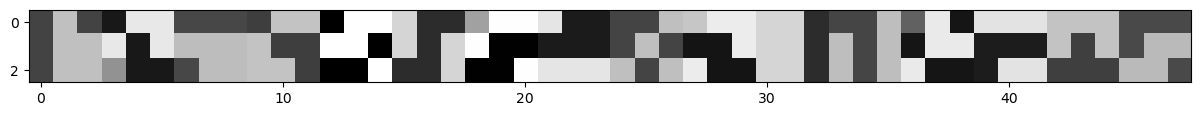

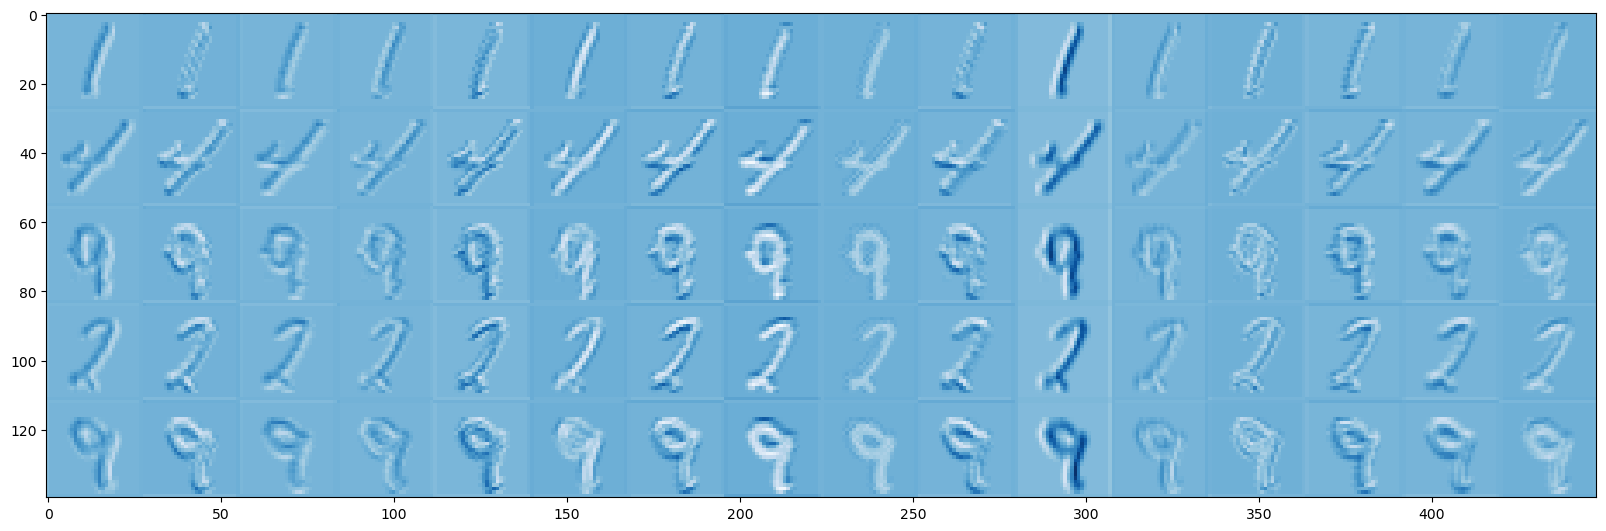

In [130]:
with torch.no_grad():
    out_conv1_model =  out_model.conv1(input_img.to("cuda"))
    out_conv1_weights = out_model.conv1.weight
    out_conv1_depth = torch.relu(out_model.conv1.depth_bit)
    print("Active Kernels:",torch.sum(torch.where(out_conv1_depth>0,1,0)))
    
    # print(out_conv1_depth)
    W = out_model.conv1._init_weight(out_conv1_weights,out_conv1_depth)
    W_plot = einops.rearrange(W,"k 1 f1 f2 -> f1 (k f2)").to("cpu")

    
    plt.figure(figsize=(15,8))
    plt.imshow(W_plot,cmap="gray")
    plt.show()
    plt.figure(figsize=(20,8))
    out_conv1_plot = einops.rearrange(out_conv1_model,"b k h w -> (b h) (k w)").to("cpu")
    plt.imshow(out_conv1_plot,cmap="Blues")
    plt.show()

In [123]:
torch.sum(torch.tensor([0,0,1,0,1,1]))

tensor(3)